<center style="font-size: 2em; font-weight: bold;"> Retornos a la Educacion </center>
<center style="font-size: 2em; font-weight: bold;"> Analisis de base de datos  </center>
<left style="font-size: 4em; font-weight: bold;"> Autor: Edinson Tolentino </left>

# Librerias

In [1]:
import pandas
import numpy
import os
import sys
import numpy
#from sklearn.linear_model import LinearRegression


In [2]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [3]:
import sklearn
import sklearn.compose
import category_encoders
import sklearn.impute

In [44]:
from plotnine import *
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]

## Funciones

In [49]:
def seq(start: float, stop: float, by: float, round_n=3) -> list:
    """
    Custom function, used for setting the breaks of plotnine scales.

       Parameters
    ----------
    start : float
        Start of the breaks.
    stop : float
        End of the breaks.
    by : float
        Steps between breaks.
    round_n: int, default=3
        Decimals to round floats in output.
    """
    epsilon = numpy.finfo("float").eps

    return [
        round(x, round_n) for x in list(numpy.arange(start, stop + (by - epsilon), by))
    ]

In [4]:
def normalize_frame(frame):
    """Normalize the data frame to make it performant and compatible with
    downstream libraries such as Scikit-Learn and CatBoost.
    
    In particular the following operations are performed:
    - Categorical levels that are not strings are converted into strings
    - Categorical missing values are converted into a distinct "N/A" level
    - Object-typed columns are converted into categorical columns
    """
    for col, series in frame.items():
        dtype = series.dtype
        if pandas.api.types.is_categorical_dtype(dtype):
            recode = False
            if series.hasnans:
                recode = True
            else:
                for value in series.cat.categories:
                    if not isinstance(value, str):
                        recode = True
                        break
            if recode:
                frame[col] = series.astype("str").fillna("N/A").astype(
                    "category")
        elif pandas.api.types.is_object_dtype(dtype):
            frame[col] = series.astype("str").fillna("N/A").astype("category")


In [5]:
base_transformer = sklearn.pipeline.Pipeline([
    ("recode", sklearn.compose.ColumnTransformer(transformers=[
        ("category",
             #sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore",
             sklearn.preprocessing.OneHotEncoder(drop="first",handle_unknown="ignore",                                                 
                min_frequency=0.01, max_categories=30, sparse_output= False),
             sklearn.compose.make_column_selector(dtype_exclude=numpy.number)
        ),
        ("number",
            sklearn.impute.SimpleImputer(strategy="mean"),
            sklearn.compose.make_column_selector(dtype_include=numpy.number)
        ),  
    ], n_jobs=-1)),
    #("rescale", sklearn.preprocessing.StandardScaler()),
])

# Analisis

## Carga de data

In [6]:
output           = "C:/Users/et396/Dropbox/Docencia/Educate/Econometria/S1/Data"
os.chdir(output)

In [7]:
base = pandas.read_stata("Mincer_2021.dta")

## Filtras variables

In [8]:
response = ['lnr6']
input = ['reduca', 'rmujer','redad','redadsq', 'rDpto']

data_fit = base[response+input]

In [9]:
data_fit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24774 entries, 0 to 24773
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lnr6     24774 non-null  float64
 1   reduca   24774 non-null  float64
 2   rmujer   24774 non-null  int32  
 3   redad    24774 non-null  int32  
 4   redadsq  24774 non-null  int32  
 5   rDpto    24774 non-null  object 
dtypes: float64(2), int32(3), object(1)
memory usage: 871.1+ KB


In [10]:
normalize_frame(data_fit)
data_fit.sample(8).head().T

C:\Users\et396\AppData\Local\Temp\ipykernel_7820\2625916019.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pandas.api.types.is_categorical_dtype(dtype):
C:\Users\et396\AppData\Local\Temp\ipykernel_7820\2625916019.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[col] = series.astype("str").fillna("N/A").astype("category")


,23591,1277,15299,12608,3247
lnr6,7.044614,7.469607,7.006091,4.405702,5.531081
reduca,11.0,16.0,11.0,3.0,7.0
rmujer,0,1,0,1,0
redad,54,26,35,57,34
redadsq,2916,676,1225,3249,1156
rDpto,Tacna,Cusco,Lambayeque,Huanuco,Loreto


In [11]:
data_fit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24774 entries, 0 to 24773
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   lnr6     24774 non-null  float64 
 1   reduca   24774 non-null  float64 
 2   rmujer   24774 non-null  int32   
 3   redad    24774 non-null  int32   
 4   redadsq  24774 non-null  int32   
 5   rDpto    24774 non-null  category
dtypes: category(1), float64(2), int32(3)
memory usage: 702.5 KB


## Seleccion variables

In [12]:
response = data_fit[['lnr6']]

In [13]:
inputs   = data_fit[['reduca', 'rmujer','redad','redadsq']]

## Modelo Lineal

In [14]:

#inputs   = statsmodels.tools.add_constant(inputs, has_constant='raise')
#inputs   = sm.add_constant(inputs, has_constant='')
inputs   = sm.add_constant(inputs)

model    = sm.OLS( response, inputs)
#model = statsmodels.regression.linear_model.OLS(response, inputs)

model_lineal = model.fit()

print(model_lineal.summary())

                            OLS Regression Results                            
Dep. Variable:                   lnr6   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     917.6
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:50:21   Log-Likelihood:                -40854.
No. Observations:               24774   AIC:                         8.172e+04
Df Residuals:                   24769   BIC:                         8.176e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3629      0.114     38.434      0.0

## Linear regresion robust

In [15]:
model_r = sm.RLM( response, inputs, M=sm.robust.norms.HuberT())
model_lineal_r = model_r.fit()
print(model_lineal_r.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                   lnr6   No. Observations:                24774
Model:                            RLM   Df Residuals:                    24769
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 03 Mar 2024                                         
Time:                        18:50:21                                         
No. Iterations:                    24                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7142      0.080     59.132      0.0

In [16]:
model_glm = sm.GLM( response, inputs)
model_lineal_glm = model_glm.fit()
print(model_lineal_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   lnr6   No. Observations:                24774
Model:                            GLM   Df Residuals:                    24769
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                          1.5848
Method:                          IRLS   Log-Likelihood:                -40854.
Date:                Sun, 03 Mar 2024   Deviance:                       39253.
Time:                        18:50:21   Pearson chi2:                 3.93e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1377
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3629      0.114     38.434      0.0

## Presentacion de modelos

In [17]:
inputs0 = base['reduca']
inputs0 = sm.add_constant(inputs0)
m0 = sm.OLS( response, inputs0).fit()
m1 = sm.OLS( response, inputs).fit()


In [18]:
resumen_lineal = summary_col([m0,m1], regressor_order=m1.params.index.tolist(), stars=True, float_format='%.3f')
print(resumen_lineal)


                lnr6 I   lnr6 II 
---------------------------------
const          6.085*** 4.363*** 
               (0.015)  (0.114)  
reduca         0.072*** 0.071*** 
               (0.001)  (0.001)  
rmujer                  -0.479***
                        (0.018)  
redad                   0.094*** 
                        (0.005)  
redadsq                 -0.001***
                        (0.000)  
R-squared      0.086    0.129    
R-squared Adj. 0.086    0.129    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [19]:
os.chdir(output)
# Formato csv
#resumen_lineal.tables[0].to_csv("resumen_lineal.csv")

# Formato excel
resumen_lineal.tables[0].to_excel("resumen_lineal.xlsx")


## Inclusion de Dummy

In [20]:
predictors_cols   = ['reduca', 'rmujer','redad','redadsq', 'rDpto']

In [21]:
data_fit  = base[predictors_cols]


In [22]:

predictors  = data_fit[predictors_cols]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=data_fit.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")


In [23]:
inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24774 entries, 0 to 24773
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   const                          24774 non-null  float64
 1   category__rDpto_Ancash         24774 non-null  float64
 2   category__rDpto_Apurimac       24774 non-null  float64
 3   category__rDpto_Arequipa       24774 non-null  float64
 4   category__rDpto_Ayacucho       24774 non-null  float64
 5   category__rDpto_Cajamarca      24774 non-null  float64
 6   category__rDpto_Callao         24774 non-null  float64
 7   category__rDpto_Cusco          24774 non-null  float64
 8   category__rDpto_Huancavelica   24774 non-null  float64
 9   category__rDpto_Huanuco        24774 non-null  float64
 10  category__rDpto_Ica            24774 non-null  float64
 11  category__rDpto_Junin          24774 non-null  float64
 12  category__rDpto_La Libertad    24774 non-null 

In [24]:
m2 = sm.OLS( response, inputs).fit() 
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:                   lnr6   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     153.0
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:50:24   Log-Likelihood:                -40588.
No. Observations:               24774   AIC:                         8.123e+04
Df Residuals:                   24745   BIC:                         8.147e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [25]:
resumen_lineal = summary_col([m2], regressor_order=m1.params.index.tolist(), stars=True, float_format='%.3f')
print(resumen_lineal)


                                 lnr6  
---------------------------------------
const                         4.485*** 
                              (0.118)  
category__rDpto_Ancash        0.004    
                              (0.056)  
number__redadsq               -0.001***
                              (0.000)  
number__redad                 0.091*** 
                              (0.005)  
number__rmujer                -0.483***
                              (0.018)  
number__reduca                0.067*** 
                              (0.002)  
category__rDpto_Ucayali       0.037    
                              (0.057)  
category__rDpto_Tumbes        0.147**  
                              (0.063)  
category__rDpto_Tacna         -0.066   
                              (0.057)  
category__rDpto_San Martin    0.122**  
                              (0.055)  
category__rDpto_Puno          -0.612***
                              (0.059)  
category__rDpto_Piura         0.099*   

In [26]:
predictors_cols   = ['reduca']
data_fit  = base[predictors_cols]
predictors  = data_fit[predictors_cols]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=data_fit.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

In [27]:
m3 = sm.OLS( response, inputs).fit() 

In [28]:
predictors_cols   = ['reduca', 'rmujer','redad','redadsq']
data_fit  = base[predictors_cols]
predictors  = data_fit[predictors_cols]
transformer = sklearn.clone(base_transformer)
inputs      = transformer.fit_transform(predictors)
inputs      = pandas.DataFrame(inputs, index=data_fit.index,
                               columns=transformer.get_feature_names_out())
inputs      = sm.add_constant(inputs, has_constant="raise")

In [29]:
m4 = sm.OLS( response, inputs).fit() 

In [30]:
resumen_lineal = summary_col([m3, m4, m2], regressor_order=m1.params.index.tolist(), stars=True, float_format='%.3f')
print(resumen_lineal)


                               lnr6 I   lnr6 II   lnr6 III
----------------------------------------------------------
const                         6.085*** 4.363***  4.485*** 
                              (0.015)  (0.114)   (0.118)  
number__reduca                0.072*** 0.071***  0.067*** 
                              (0.001)  (0.001)   (0.002)  
category__rDpto_Ucayali                          0.037    
                                                 (0.057)  
category__rDpto_Tumbes                           0.147**  
                                                 (0.063)  
category__rDpto_Tacna                            -0.066   
                                                 (0.057)  
category__rDpto_San Martin                       0.122**  
                                                 (0.055)  
category__rDpto_Puno                             -0.612***
                                                 (0.059)  
category__rDpto_Piura                            0.099*

In [34]:
m2.params

const                            4.485094
category__rDpto_Ancash           0.004050
category__rDpto_Apurimac        -0.027885
category__rDpto_Arequipa         0.161097
category__rDpto_Ayacucho        -0.189389
category__rDpto_Cajamarca       -0.204315
category__rDpto_Callao           0.074845
category__rDpto_Cusco           -0.114674
category__rDpto_Huancavelica    -0.429405
category__rDpto_Huanuco         -0.175318
category__rDpto_Ica              0.226132
category__rDpto_Junin           -0.117805
category__rDpto_La Libertad      0.056243
category__rDpto_Lambayeque       0.137234
category__rDpto_Lima             0.112958
category__rDpto_Loreto          -0.176129
category__rDpto_Madre de Dios    0.203202
category__rDpto_Moquegua         0.130010
category__rDpto_Pasco           -0.157750
category__rDpto_Piura            0.099197
category__rDpto_Puno            -0.611791
category__rDpto_San Martin       0.121577
category__rDpto_Tacna           -0.066355
category__rDpto_Tumbes           0

In [38]:
m2.params[27] / (2* m2.params[28])

C:\Users\et396\AppData\Local\Temp\ipykernel_7820\2814395017.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m2.params[27] / (2* m2.params[28])


-43.11407115177062

## Grafico 1

In [47]:
data_fit['reduca'].describe()

count    24774.000000
mean         8.698151
std          5.497429
min          0.000000
25%          4.000000
50%         11.000000
75%         12.000000
max         18.000000
Name: reduca, dtype: float64

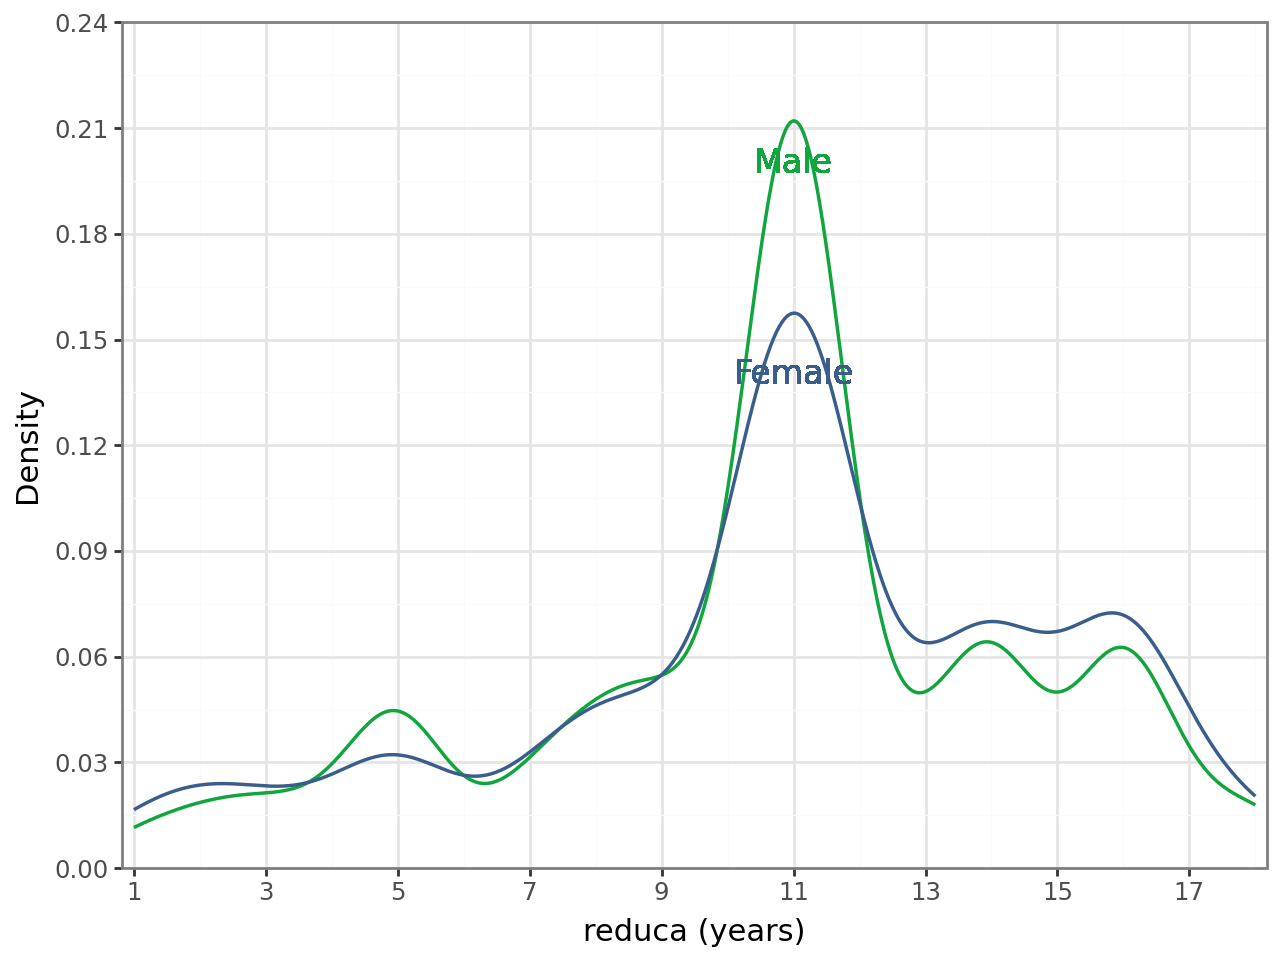

In [56]:

(
    ggplot(data_fit, aes(x='reduca', y='stat(density)', color='factor(rmujer)'))
    + geom_density(adjust=1.5, show_legend=False, na_rm=True, size=0.7)
    + labs(x="reduca (years)", y="Density", color="")
    + scale_color_manual(
        name="", values=(color[1], color[0]), labels=("Male", "Female")
    )
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 18), breaks=seq(1, 18, by=2))
    + scale_y_continuous(
        expand=(0.0, 0.0), limits=(0, 0.24), breaks=seq(0, 0.24, by=0.03)
    )
    + geom_text(aes(x=11, y=0.20, label="'Male'"), color=color[1], size=12)
    + geom_text(aes(x=11, y=0.14, label="'Female'"), color=color[0], size=12)
    + theme_bw()
    
)
